### Assignment 1 - Data Preprocessing, Exploration, and Insight Discovery
course: CMPS 460


## Part A

Context: online shopping session analytics. Each session includes browsing behavior (durations, bounce/exit rates, page value signals) and a binary purchase outcome (`Revenue`).

Why this dataset fits the assignment:
- enough volume for stable EDA patterns
- mixed feature types (continuous + categorical + binary)
- realistic noise: skewed durations, sparse value signals, and duplicate sessions

Practical relevance:
- conversion funnel diagnostics
- website optimization based on behavior patterns
- visitor segmentation for campaign and UX decisions

Source:
- UCI dataset page: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')
sns.set_palette('flare')


In [13]:
shop = pd.read_csv('data/online_shoppers_full.csv')
shop.shape


(12330, 18)

## Part B

In [14]:
shop.head(3)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [15]:
print(shop.info())
print(shop.describe(include='all').T.head(12))
print('missing counts:')
print(shop.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [16]:
df = shop.copy()

# normalize text style
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# bool -> int for easier summaries
bool_cols = [c for c in df.columns if df[c].dtype == bool]
for c in bool_cols:
    df[c] = df[c].astype(int)

# if any numeric missing appears, use median
for c in df.select_dtypes(include=np.number).columns:
    if df[c].isna().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

# duplicates
n0 = len(df)
df = df.drop_duplicates()
print('duplicate rows removed:', n0 - len(df))


duplicate rows removed: 125


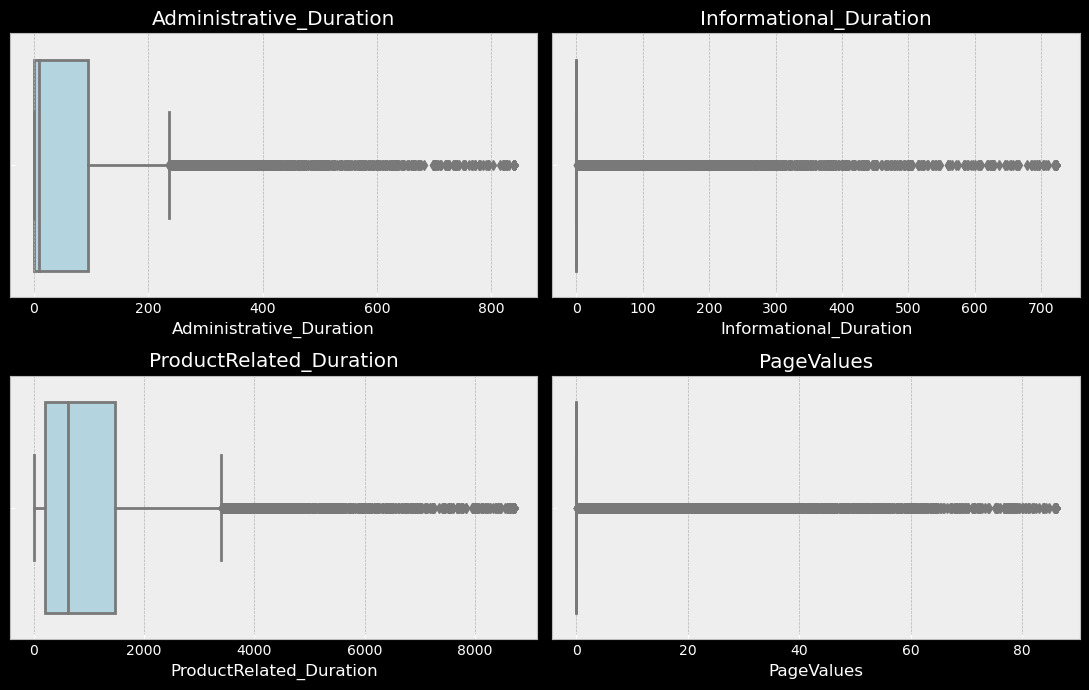

In [17]:
# outlier treatment for some skewed variables
# reason for this step: long tails were dominating distributions
skew_cols = ['Administrative_Duration','Informational_Duration','ProductRelated_Duration','PageValues']
for c in skew_cols:
    lo, hi = df[c].quantile([0.01, 0.99])
    df[c] = df[c].clip(lo, hi)

fig, ax = plt.subplots(2,2, figsize=(11,7))
for i,c in enumerate(skew_cols):
    sns.boxplot(x=df[c], ax=ax[i//2, i%2], color='lightblue')
    ax[i//2, i%2].set_title(c)
plt.tight_layout()


I treated outliers by clipping only the extreme 1 percent tails on selected duration/value features. I avoided deleting rows because those sessions may still be valid user behavior. This choice makes the visual analysis more readable while preserving most observations.

In [18]:
# feature prep
# month order cleanup for visualization
month_order = ['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

encoded = pd.get_dummies(df, columns=['Month','VisitorType'], drop_first=True)
print('encoded shape', encoded.shape)


encoded shape (12205, 27)


## Part C1 - Univariate

In [19]:
cols = ['PageValues', 'BounceRates', 'ExitRates', 'ProductRelated']
summary = []

for col_name in cols:
    s = df[col_name]
    summary.append({
        'feature': col_name,
        'mean': round(s.mean(), 3),
        'median': round(s.median(), 3),
        'mode': round(s.mode().iloc[0], 3),
        'var': round(s.var(), 3),
        'std': round(s.std(), 3),
        'iqr': round(s.quantile(0.75) - s.quantile(0.25), 3),
    })

pd.DataFrame(summary)


,feature,mean,median,mode,var,std,iqr
0,PageValues,5.496,0.000,0.0,223.275,14.942,0.000
1,BounceRates,0.020,0.003,0.0,0.002,0.045,0.017
2,ExitRates,0.041,0.025,0.2,0.002,0.046,0.034
3,ProductRelated,32.046,18.000,1.0,1988.594,44.594,30.000


These descriptive stats were meant to compare engagement and exit behavior quickly. PageValues is highly skewed with a median at zero, while ProductRelated has large variance, so the dataset clearly mixes short low-intent sessions with deeper browsing sessions.

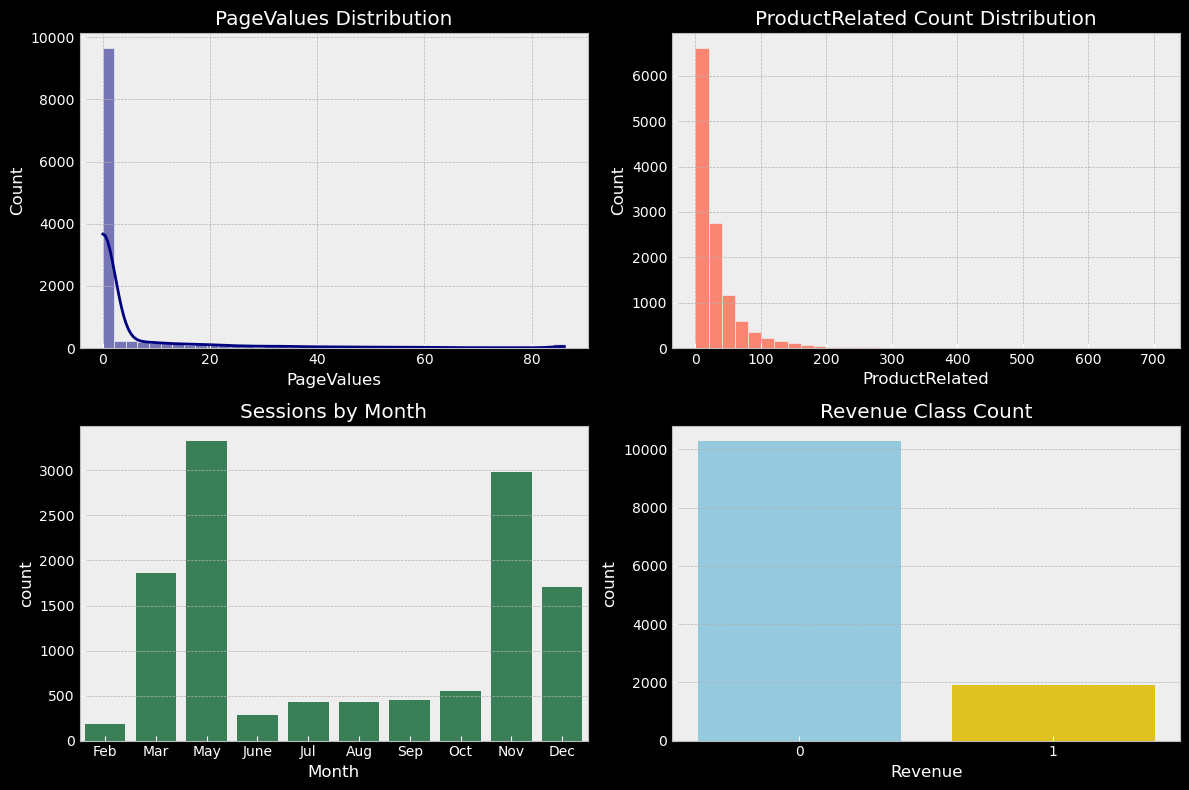

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df['PageValues'], bins=40, kde=True, ax=ax[0, 0], color='navy')
ax[0, 0].set_title('PageValues Distribution')

sns.histplot(df['ProductRelated'], bins=35, ax=ax[0, 1], color='tomato')
ax[0, 1].set_title('ProductRelated Count Distribution')

sns.countplot(x='Month', data=df, ax=ax[1, 0], color='seagreen')
ax[1, 0].set_title('Sessions by Month')

sns.countplot(x='Revenue', data=df, ax=ax[1, 1], palette=['skyblue', 'gold'])
ax[1, 1].set_title('Revenue Class Count')

plt.tight_layout()


The univariate charts confirm the same story visually: many sessions have low page value, product browsing depth varies a lot, and traffic is concentrated in certain months. Revenue is also imbalanced toward non-purchase sessions.

## Part C2 - Bivariate / Multivariate

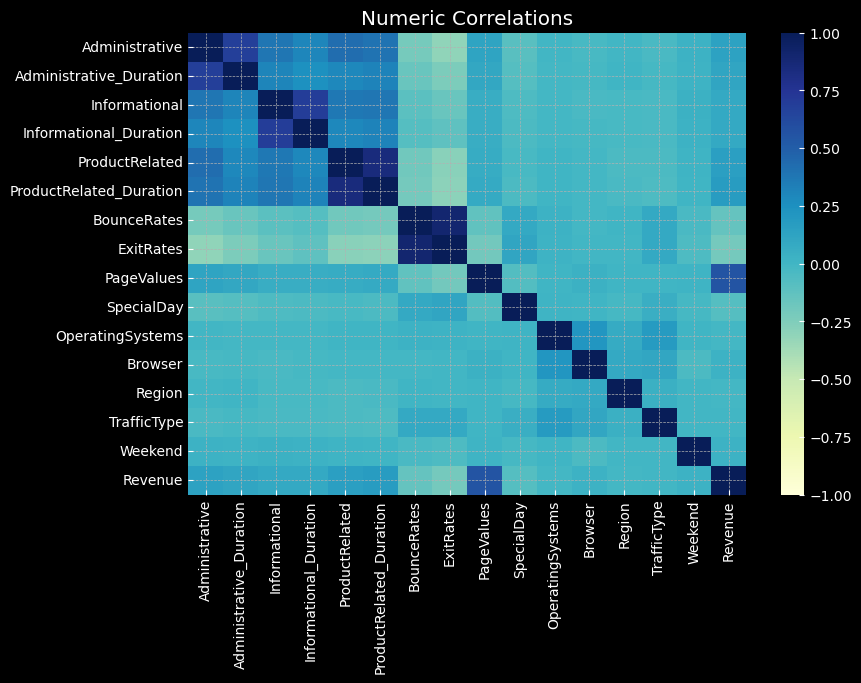

In [21]:
numeric = df.select_dtypes(include=np.number)
plt.figure(figsize=(9, 6))
sns.heatmap(numeric.corr(), cmap='YlGnBu', center=0, vmin=-1, vmax=1)
plt.title('Numeric Correlations')
plt.show()


The correlation heatmap helps identify which browsing metrics move together. Some features are connected, but none of them fully replace the others, so keeping multiple behavior features is useful.

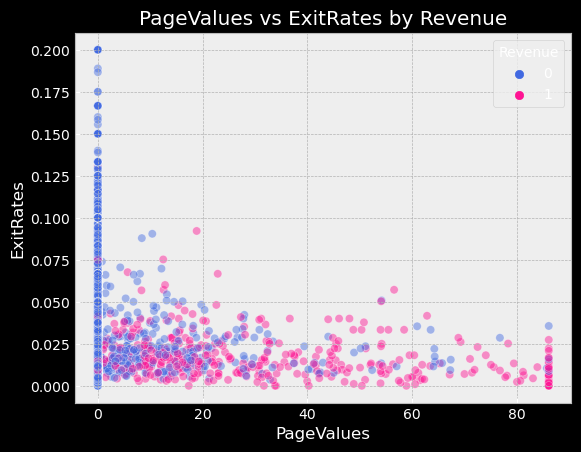

In [26]:
# Q1: Do higher page values connect to conversions?
sub = df.sample(3000, random_state=5)
sns.scatterplot(
    data=sub,
    x='PageValues',
    y='ExitRates',
    hue='Revenue',
    palette={0: 'royalblue', 1: 'deeppink'},
    alpha=0.45,
)
plt.title('PageValues vs ExitRates by Revenue')
plt.show()


The PageValues vs ExitRates scatter shows that conversion sessions are denser where page value is higher and exit tendency is lower.

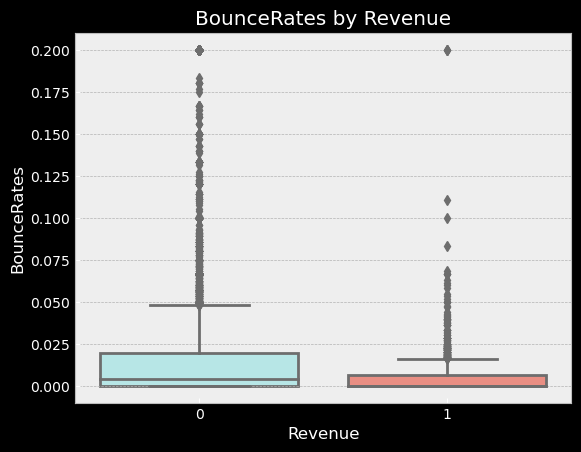

In [27]:
# Q2: Bounce rate difference by target
sns.boxplot(data=df, x='Revenue', y='BounceRates', palette=['paleturquoise', 'salmon'])
plt.title('BounceRates by Revenue')
plt.show()


The BounceRates boxplot supports that pattern because revenue sessions have lower bounce values overall.

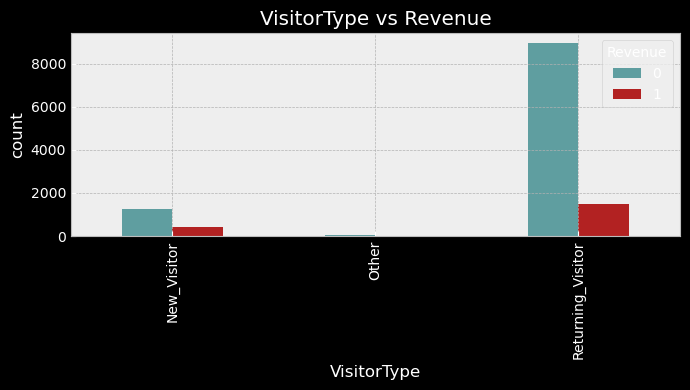

In [28]:
# Q3: Visitor type and conversion
table_v = pd.crosstab(df['VisitorType'], df['Revenue'])
table_v[[0, 1]].plot(kind='bar', figsize=(7, 4), color=['cadetblue', 'firebrick'])
plt.title('VisitorType vs Revenue')
plt.ylabel('count')
plt.tight_layout()
plt.show()


The visitor-type bar chart adds segmentation context and shows conversion is not evenly distributed across visitor groups.

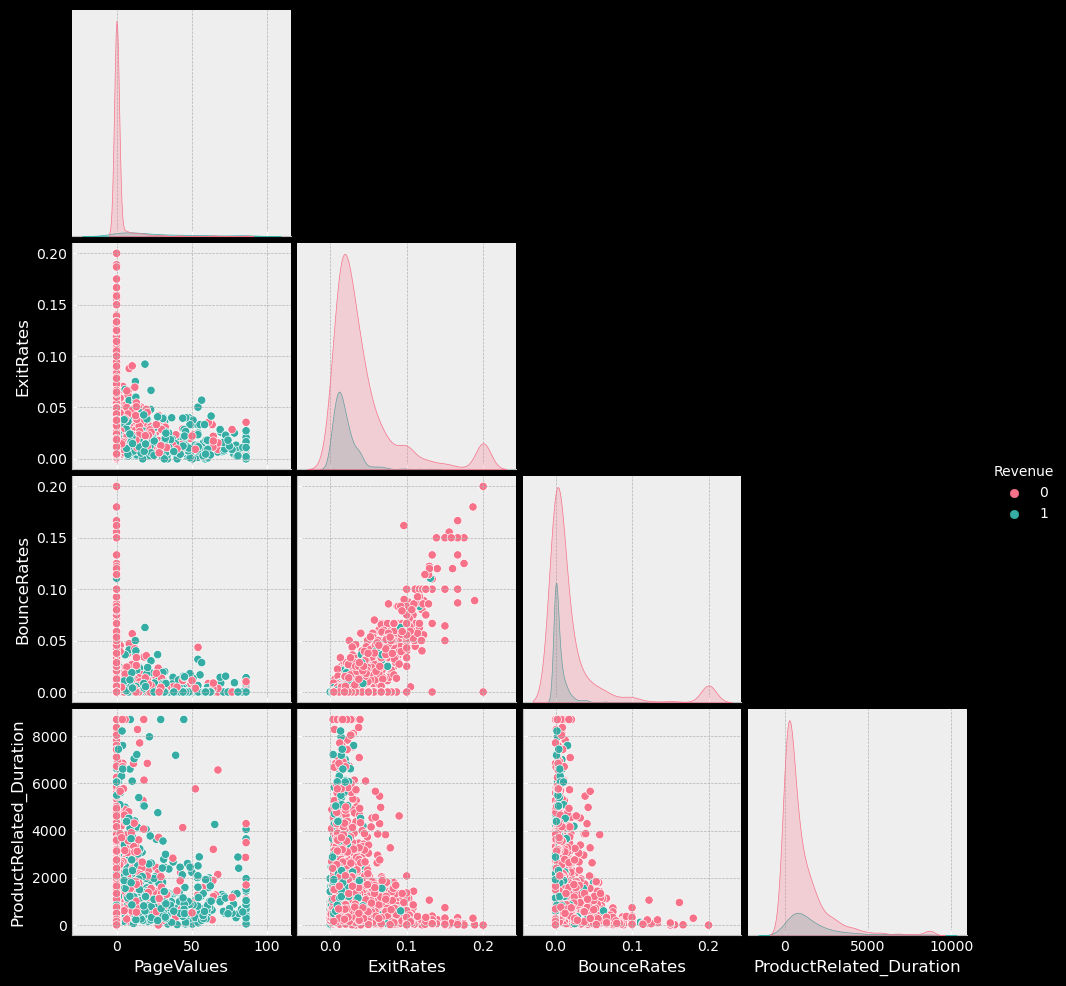

In [29]:
# Q4: multivariate sample
sns.pairplot(
    sub[['PageValues', 'ExitRates', 'BounceRates', 'ProductRelated_Duration', 'Revenue']],
    hue='Revenue',
    corner=True,
    palette='husl',
)
plt.show()


The pairplot confirms this is a multi-signal problem, where better separation appears only when several session features are viewed together.

## Findings

Quick business readout: sessions with higher PageValues, lower bounce, and lower exit behavior are much more likely to end in purchase. Month and visitor-type distributions show traffic behavior is not uniform over time or user groups. Overall, conversion appears to be a multi-signal behavior pattern rather than a single-feature effect.
